# Phase Picking (PhaseNet), Polarity (DiTingMotion)

Next, I will use `PhaseNet` and `Pyrocko` to pick P and S phases and their polarity.
Lastly, I will use `HASH(fortran)` and `SKHASH (python)` to determine the focal mechanisms.

---

### Import all necessary libraries here, this will make things easier later

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
# from tensorflow.keras import backend as K
#pip install --upgrade keras tensorflow if conda install keras causes ImportError:

# Setup all directories

In [2]:
# set up the project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_dir, "data/eq_data")
catalog_dir = os.path.join(data_dir, "1_eq_catalogs")
waveform_dir = os.path.join(data_dir, "2_waveforms")
station_dir = os.path.join(data_dir, "3_station_catalogs")

pn_dt_dir = os.path.join(project_dir, "results/phasenet_diting_others")
pn_dir = os.path.join(pn_dt_dir, "phasenet_files")
os.makedirs(pn_dir, exist_ok=True)


# 2. Determine polarity using DitingMotion

In [3]:
phasnet_picks = f"{pn_dir}/PN_w_stdist_varified_921.csv"
phasenet_df = pd.read_csv(phasnet_picks, parse_dates=["begin_time", "phase_time"])
phasenet_df = phasenet_df[(phasenet_df.phase_type == "P")] # filter out only P picks

mseed_list = [f for f in os.listdir(f'{waveform_dir}') if f.endswith('.mseed')]

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
diting_model_dir = os.path.abspath(os.path.join(os.getcwd(), "./DiTing_model/models/DiTingMotionJul.hdf5"))
diting_model = tf.keras.models.load_model(diting_model_dir, compile=False)

## Use function in my custom clases

if parallelized function is causing issues with tensorflow, use regular for loop.

In [4]:
# import warnings
# warnings.filterwarnings("ignore")

from classes_functions.my_class_funcs import DitingMotionPicker
%reload_ext autoreload
%autoreload 2

run = input("Do you want to run DiTing Motion Picker now? (y/n): ")
# run = "y"
if run.lower() == "y":
    dmp = DitingMotionPicker(
        mseed_list=mseed_list,
        waveform_dir=f"{waveform_dir}",
        phasenet_picks_df=phasenet_df,
        motion_model=diting_model,
        correct_pn_picks = -0.0, # already corrected in Phasenet picks verified.csv file for 0.1s
        )
    par = input("Run in parallel? (y/n): ").lower()
    # par = "y"
    if par == "y":
        pol_pick_df = dmp.assign_polarity_parallel()
        pol_pick_df.to_csv(f"{pn_dir}/dt_pn_varified_par_921.csv", index=False)
    elif par == "n":
        pol_pick_df = dmp.assign_polarity()
        pol_pick_df.to_csv(f"{pn_dir}/dt_pn_varified_921.csv", index=False)
    else:
        print("Invalid input. Exiting...")
        exit()
       

Running parallel processing with 22 cores


Polarity Detection:   0%|          | 0/921 [00:00<?, ?it/s]

# 3. Convert PyRocko picks into phasenet format csv file
add pyrocko phase time, phase polarity as new columns to the phasenet pick file.

In [5]:
ppick_file = f'{pn_dir}/dt_pn_varified_par_921.csv' 
pyrocko_markers = f'{project_dir}/results/phasenet_diting_others/00_master_marker_ASSOCIATED_v3.txt'

outpath_allpick = f'{pn_dir}/ALL_PICKS_POL_921.csv'

from classes_functions.my_class_funcs import MyFileConverter
%reload_ext autoreload
%autoreload 2

mfc = MyFileConverter()
all_picks_df = mfc.convert_pyrocko_picks_to_phasenet(pyrocko_markers, ppick_file)

# all_picks_df.sort_values(by='file_name', inplace=True) # sort by file_name
# all_picks_df.reset_index(drop=True, inplace=True) # reset index
all_picks_df.to_csv(outpath_allpick, index=False) 
print(outpath_allpick)

Skipping XQ.ME50.01.BH - nc71100926.mseed - P - None
Skipping BK.GASB..HH - nc71100926.mseed - P - None
Skipping NC.GHM..EH - nc71100926.mseed - P - None
Skipping BK.JCC..HH - nc51197189.mseed - P - None
Skipping XQ.ME31.01.BH - nc51197189.mseed - P - 0
Skipping XQ.ME32.01.BH - nc51197189.mseed - P - None
Skipping BK.YBH..HH - nc51197189.mseed - P - 0
Skipping NC.KSXB..HH - nc51197189.mseed - P - None
Skipping XQ.ME08.01.BH - nc51197189.mseed - P - None
Skipping XQ.ME39.01.BH - nc51197189.mseed - P - None
Skipping NC.GTS..EH - nc40216664.mseed - P - None
Skipping XQ.ME57.01.BH - nc40221138.mseed - P - None
Skipping NC.KMR..HH - nc51207076.mseed - P - None
Skipping XQ.ME50.01.BH - nc51207076.mseed - P - None
Skipping XQ.ME43.01.BH - nc51207076.mseed - P - None
Skipping XQ.ME36.01.BH - nc51207214.mseed - P - None
Skipping NC.KCPB..HH - nc51207214.mseed - P - None
Skipping BK.JCC..HH - nc51207214.mseed - P - None
Skipping XQ.ME34.01.BH - nc51207214.mseed - P - None
Skipping XQ.ME50.01.BH 

### Add Station-to-event distance to the PhaseNet picks file 'ALL_PICKS_POL_new2.csv'

In [6]:
inv_file = f'{project_dir}/data/eq_data/3_station_catalogs/' + '00_station_inventory_921.txt'
eq_cat_file = f'{catalog_dir}/usgs_catalog_2008-01-01_2024-01-01_M2.csv'
pn_pick_file = f'{pn_dir}/ALL_PICKS_POL_921.csv'
outpath_allpick = f'{pn_dir}/ALL_PICKS_POL_921.csv'

# Add distance column to the pick dataframe
from classes_functions.other_fun import add_sta_dist_to_polpick
%reload_ext autoreload
%autoreload 2
pn_pick_w_dist_df = add_sta_dist_to_polpick(eq_cat_file, pn_pick_file, inv_file)

pn_pick_w_dist_df = pn_pick_w_dist_df.sort_values(by=['file_name', 'sta_dist_km'])
# remove if phase_time is none or NaT or simply missing
pn_pick_w_dist_df = pn_pick_w_dist_df.dropna(subset=['phase_time'])

# save the dataframe
pn_pick_w_dist_df.to_csv(outpath_allpick, index=False) 
print(outpath_allpick)

/Users/mdaislam/Library/CloudStorage/OneDrive-IndianaUniversity/Research/Github/FM2STRESS/FM2STRESS_project/results/phasenet_diting_others/phasenet_files/ALL_PICKS_POL_921.csv


## Distribution

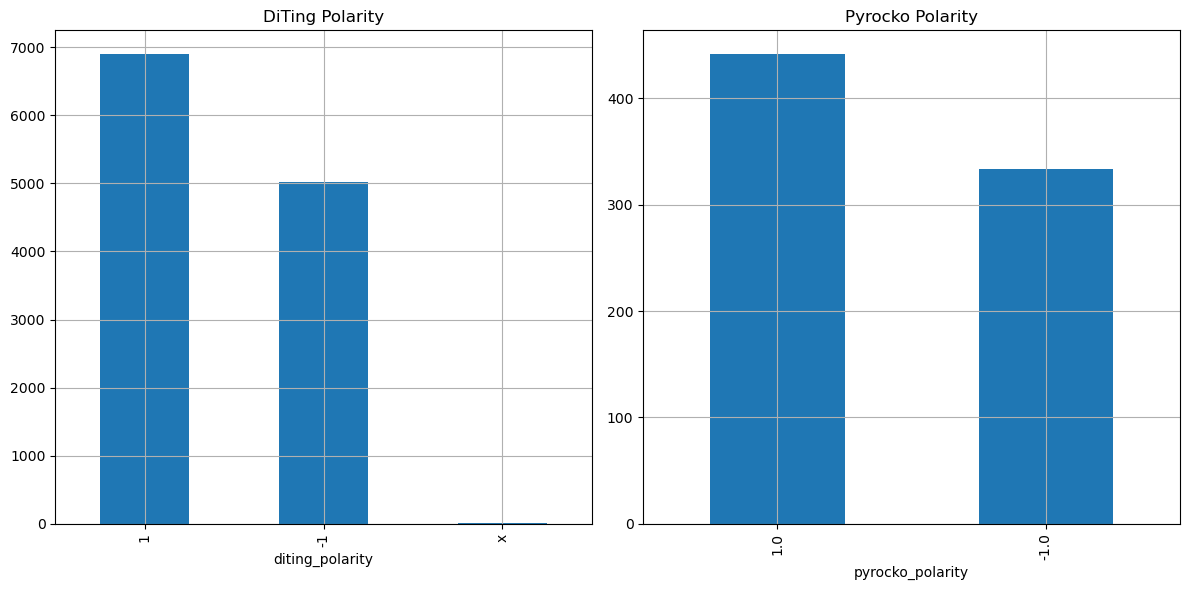

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pn_pick_w_dist_df.diting_polarity.value_counts().plot(kind='bar', ax=ax[0], grid=True)
pn_pick_w_dist_df.pyrocko_polarity.value_counts().plot(kind='bar', ax=ax[1], grid=True)

ax[0].set_title("DiTing Polarity")
ax[1].set_title("Pyrocko Polarity")

plt.tight_layout()
plt.show()